# Imports


In [2]:
import glob
import re
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

# Plot errors


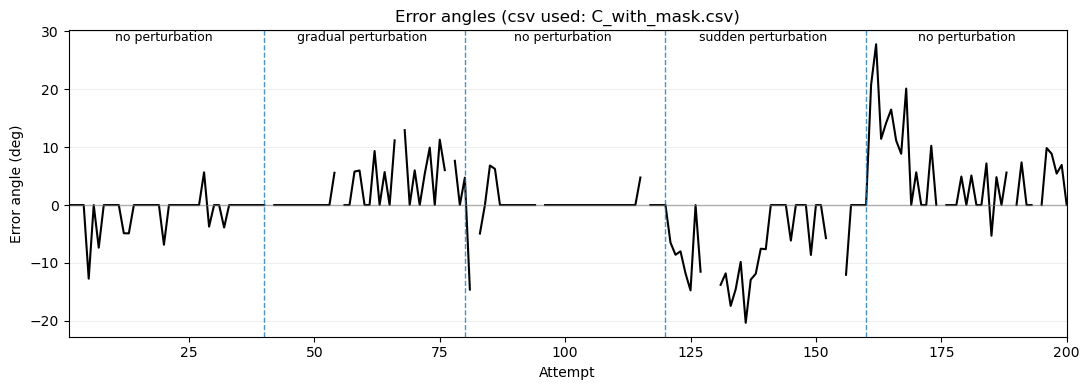

In [5]:
# pattern = re.compile(r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})\.csv$")
# csv_files = [name for name in glob.glob('*.csv') if pattern.match(name)]
# if not csv_files:
#     raise FileNotFoundError('No timestamped CSV files found in the current directory.')
# def _parse_timestamp(name: str) -> datetime:
#     match = pattern.match(name)
#     return datetime.strptime(match.group(1), '%Y-%m-%d_%H-%M-%S')
# latest_csv = max(csv_files, key=_parse_timestamp)

csv = "C_without_mask.csv"
csv = "C_with_mask.csv"
df = pd.read_csv(csv)

errors = df['error_angle_deg'].to_numpy()
attempts = list(range(1, len(errors) + 1))

fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(attempts, errors, color='black', linewidth=1.5)
ax.axhline(0, color='gray', linewidth=1, alpha=0.6)

phase_boundaries = [40, 80, 120, 160]
phase_labels = [
    (1, 39, 'no perturbation'),
    (40, 79, 'gradual perturbation'),
    (80, 119, 'no perturbation'),
    (120, 159, 'sudden perturbation'),
    (160, None, 'no perturbation'),
]

for boundary in phase_boundaries:
    if boundary <= len(errors):
        ax.axvline(boundary, color='tab:blue', linestyle='--', linewidth=1, alpha=0.8)

for start, end, label in phase_labels:
    if start > len(errors):
        continue
    span_end = len(errors) if end is None else min(end, len(errors))
    if span_end < start:
        continue
    mid = (start + span_end) / 2
    ax.text(mid, max(errors) if len(errors) else 0, label, ha='center', va='bottom', fontsize=9)

ax.set_title(f'Error angles (csv used: {csv})')
ax.set_xlabel('Attempt')
ax.set_ylabel('Error angle (deg)')
#ax.set_ylim(-180, 180)
ax.set_xlim(1, max(1, len(errors)))
ax.grid(True, axis='y', alpha=0.2)
plt.tight_layout()
plt.show()
